In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import xgboost as xgb
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from textblob import TextBlob
from unidecode import unidecode
from statsmodels.stats.weightstats import ztest
from gensim import corpora
from gensim.models import LdaModel

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shfovt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/shfovt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/shfovt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/shfovt/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
## Import the data
data = pd.read_csv('Suicide_Detection.csv').drop('Unnamed: 0', axis = 1)

# Sample data for computation purpose
data = data.sample(5000, random_state= 10)
data.head()

,text,class
24765,ANYBODY WHO CAN PHOTO SHOP(simply cropping out...,non-suicide
20560,question to my fellow asian-americans &amp; fi...,non-suicide
154132,Merry Christmas &lt;3,non-suicide
99151,I'm probably gonna end it soon.I've posted her...,suicide
210422,"Waking Up, Back to Sleep I've been dealing wi...",suicide


## 1. Exploratory Data Analysis

<h4> Suicide and non-sucicide observations are equally distributed in the dataset </h4>

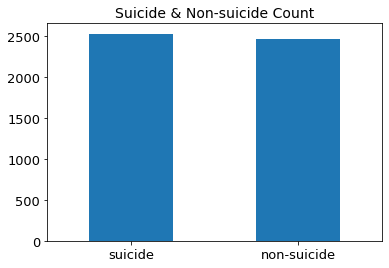

In [3]:
data['class'].value_counts().plot.bar(fontsize = 13)
plt.xticks(rotation = 360)
plt.title('Suicide & Non-suicide Count', fontsize = 14)
plt.show()

<h4> Suicide posts seem to have larger word count than non-suicide posts </h4>

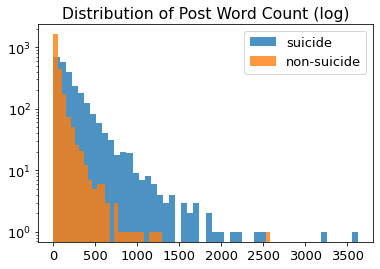

In [4]:
# Count word in each post
data['word count'] = data['text'].apply(lambda x: len(word_tokenize(x)))

plt.rcParams.update({'font.size': 13})
plt.hist(data.loc[data['class'] == 'suicide', 'word count'], bins = 50, alpha = 0.8)
plt.hist(data.loc[data['class'] == 'non-suicide', 'word count'], bins = 50, alpha = 0.8)
plt.legend(['suicide', 'non-suicide'])
plt.yscale('log')
plt.title('Distribution of Post Word Count (log)')
plt.show()

## 2. Data Transformation

In [5]:
Y = data['class'].map({'non-suicide': 0, 'suicide': 1})
posts = data['text'].to_list()

In [6]:
# # Locate repetitive letters in the posts (those words usually represent emotion)
# pattern = re.compile(r'(.)\1\1+')
# # matches = pattern.(' '.join(extended_df.columns.values))

# re.sub(r'(.)\1\1+', '.',' '.join(extended_df.columns.values))

In [7]:
# Word Tokenization
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize the text & Remove unicode of the text
    tokens = word_tokenize(unidecode(text.lower()))

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    return ' '.join(lemmatized_tokens)

documents = [preprocess_text(doc) for doc in posts]
data['text_new'] = np.array(documents)

In [8]:
pd.DataFrame({'document':[f'Document {i+1}' for i in range(len(documents))],
             'text': documents}).set_index('document')

,text
document,
Document 1,anybody photo shop simply cropping image pasti...
Document 2,question fellow amp filipino get hella nervous...
Document 3,merry christmas lt
Document 4,probably gon na end posted numorous time year ...
Document 5,waking back sleep dealing integrating lot smal...
...,...
Document 4996,must life cruel
Document 4997,know take much longeri feel awful several mont...
Document 4998,ofc always weekend wan na post pic video smh s...


## 3. Sentiment Analysis

In [9]:
data['polarity'] = data['text_new'].apply(lambda x: TextBlob(x).sentiment.polarity)
data['subjectivity'] = data['text_new'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

<h4> Based on results of sentiment analysis, suicide posts seem to be more negative, passive and subjective.</h4>

### 3.1 Polarity

<h4> The average polarity of suicide posts (-0.015) are significantly lower than non-suicide posts (0.030) at 1% significance level. This phenomenon indicates that suicide posts are more negative and more likely to hold passive attitude.</h4>

In [10]:
data.groupby('class').mean('polarity')['polarity']

class
non-suicide    0.029954
suicide       -0.014565
Name: polarity, dtype: float64

In [11]:
# Polarity
test_res = ztest(data.loc[data['class'] == 'non-suicide', 'polarity'],
                 data.loc[data['class'] == 'suicide', 'polarity'])

print('z-statistics: {:.3f}'.format(test_res[0]))
print('p-value: {:.3f}'.format(test_res[1]))

z-statistics: 6.417
p-value: 0.000


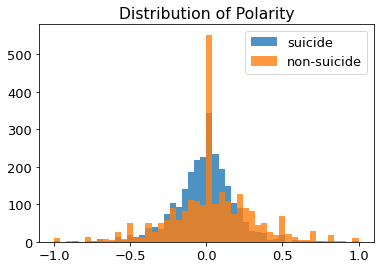

In [12]:
# Plot the distribution of polarity for suicide and non-suicide posts
plt.rcParams.update({'font.size': 13})
plt.hist(data.loc[data['class'] == 'suicide', 'polarity'], bins = 50, alpha = 0.8)
plt.hist(data.loc[data['class'] == 'non-suicide', 'polarity'], bins = 50, alpha = 0.8)
plt.legend(['suicide', 'non-suicide'])
plt.title('Distribution of Polarity')
plt.show()

### 3.2 Subjectivity

<h4> The average subjectivity of suicide posts (0.50) are significantly higher than non-suicide posts (0.47) at 1% significance level. This phenomenon indicates that suicide posts are more subjective. Their posts talk more about personal feelings and attitude. </h4>

In [13]:
data.groupby('class').mean('subjectivity')['subjectivity']

class
non-suicide    0.465975
suicide        0.503387
Name: subjectivity, dtype: float64

In [14]:
# Subjectivity
from statsmodels.stats.weightstats import ztest

test_res = ztest(data.loc[data['class'] == 'non-suicide', 'subjectivity'],
                 data.loc[data['class'] == 'suicide', 'subjectivity'])

print('z-statistics: {:.3f}'.format(test_res[0]))
print('p-value: {:.3f}'.format(test_res[1]))

z-statistics: -5.835
p-value: 0.000


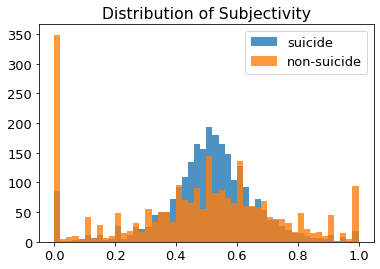

In [15]:
# Plot the distribution of subjectivity for suicide and non-suicide posts
plt.rcParams.update({'font.size': 13})
plt.hist(data.loc[data['class'] == 'suicide', 'subjectivity'], bins = 50, alpha = 0.8)
plt.hist(data.loc[data['class'] == 'non-suicide', 'subjectivity'], bins = 50, alpha = 0.8)
plt.legend(['suicide', 'non-suicide'])
plt.title('Distribution of Subjectivity')
plt.show()

## 4. Create a TF-IDF Vectorizer

In [16]:
# Create a TF-IDF Vectorizer
extended_vectorizer = TfidfVectorizer()

# Apply the vectorizer to the preprocessed dataset
extended_tfidf_matrix = extended_vectorizer.fit_transform(documents)

# Create a DataFrame for visualization
extended_df = pd.DataFrame(extended_tfidf_matrix.toarray(), columns=extended_vectorizer.get_feature_names_out())
extended_df['Document'] = [f'{i+1}' for i in range(len(documents))]
extended_df = extended_df.set_index('Document')

# Add polarity and subjectivity to the columns
extended_df[['polarity','subjectivity']] = data[['polarity','subjectivity']].values

In [17]:
extended_df.head(3)

,aaaa,aaaaa,aaaaaaaaa,aaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaand,...,zing,zip,zoloft,zombie,zone,zoning,zoom,zora,polarity,subjectivity
Document,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.166667,0.511905
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.100000,0.307143
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


## 5. Semantic Analysis

### 5.1 Semantic Analysis

In [18]:
# Tokenize the comments and create a dictionary and a corpus
tokenized_posts = [word_tokenize(post.lower()) for post in documents]
dictionary = corpora.Dictionary(tokenized_posts)
corpus = [dictionary.doc2bow(comment) for comment in tokenized_posts]

# Train the LdaModel on the corpus
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=2, random_state=42)

# Display the topics
topics = lda_model.print_topics(num_words=8)
print("Topics:")
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

Topics:
Topic 0: 0.015*"like" + 0.009*"get" + 0.009*"know" + 0.008*"would" + 0.008*"want" + 0.007*"one" + 0.007*"life" + 0.007*"year"
Topic 1: 0.014*"want" + 0.014*"feel" + 0.013*"like" + 0.012*"know" + 0.011*"life" + 0.010*"time" + 0.008*"even" + 0.007*"friend"


### 5.2 Latent Semantic Analysis

In [19]:
svd_model = TruncatedSVD(n_components=2, random_state=42)
lsa_matrix = svd_model.fit_transform(extended_df.values)

lsa_df = pd.DataFrame(lsa_matrix, columns=["topic_1", "topic_2"])
lsa_df = pd.concat([lsa_df, pd.DataFrame(data['class'].values, columns=['class'])], axis = 1)
# lsa_df['topic'] = np.where(lsa_df['topic_1'] > lsa_df['topic_2'], 1, 2)
lsa_df.head(3)

,topic_1,topic_2,class
0,0.505398,-0.162613,non-suicide
1,0.326475,-0.098861,non-suicide
2,0.002473,0.001062,non-suicide


In [20]:
lsa_df.groupby('class').mean()

,topic_1,topic_2
class,,
non-suicide,0.474449,0.034739
suicide,0.547020,-0.008997


In [21]:
# Topic1
test_res = ztest(lsa_df.loc[lsa_df['class'] == 'non-suicide', 'topic_1'],
                 lsa_df.loc[lsa_df['class'] == 'suicide', 'topic_1'])

print('z-statistics: {:.3f}'.format(test_res[0]))
print('p-value: {:.3f}'.format(test_res[1]))

z-statistics: -11.561
p-value: 0.000


In [22]:
# Topic1
test_res = ztest(lsa_df.loc[lsa_df['class'] == 'non-suicide', 'topic_2'],
                 lsa_df.loc[lsa_df['class'] == 'suicide', 'topic_2'])

print('z-statistics: {:.3f}'.format(test_res[0]))
print('p-value: {:.3f}'.format(test_res[1]))

z-statistics: 6.252
p-value: 0.000


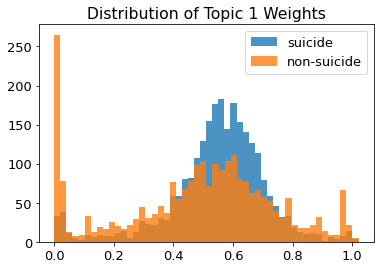

In [23]:
plt.rcParams.update({'font.size': 13})
plt.hist(lsa_df.loc[lsa_df['class'] == 'suicide', 'topic_1'], bins = 50, alpha = 0.8)
plt.hist(lsa_df.loc[lsa_df['class'] == 'non-suicide', 'topic_1'], bins = 50, alpha = 0.8)
plt.legend(['suicide', 'non-suicide'])
plt.title('Distribution of Topic 1 Weights')
plt.show()

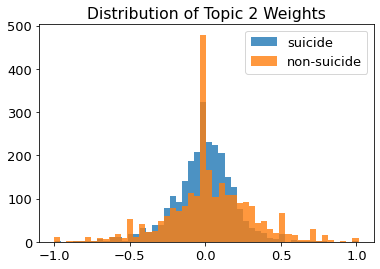

In [24]:
plt.rcParams.update({'font.size': 13})
plt.hist(lsa_df.loc[lsa_df['class'] == 'suicide', 'topic_2'], bins = 50, alpha = 0.8)
plt.hist(lsa_df.loc[lsa_df['class'] == 'non-suicide', 'topic_2'], bins = 50, alpha = 0.8)
plt.legend(['suicide', 'non-suicide'])
plt.title('Distribution of Topic 2 Weights')
plt.show()

In [25]:
# plt.figure(figsize=(10, 8))
# sns.heatmap(extended_df.values, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=extended_df.columns, yticklabels=["Doc " + str(i) for i in range(1, len(extended_df) + 1)])
# plt.title('TF-IDF Term-Document Matrix')
# plt.show()

## 6. Model Implementation

### 6.1 PCA

In [26]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(normalize(extended_df.values))

# Get the loadings (components)
loadings = pca.components_
pc = pd.DataFrame(loadings.transpose(), columns = ['PC{}'.format(x) for x in range(1,loadings.shape[0]+1)])
pc['feature'] = extended_df.columns
pc.set_index('feature', inplace = True)
# The loadings are stored in the 'components_' attribute
pc.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
feature,,,,,,,,,,
aaaa,0.000319,-0.000457,-0.000870,-0.000257,-0.000118,-0.000356,0.000528,0.000010,-0.000387,0.000044
aaaaa,-0.000477,0.000318,-0.000457,-0.000471,0.002645,-0.001185,-0.000367,-0.000762,0.002158,0.000047
aaaaaaaaa,0.000385,-0.000311,-0.000530,-0.000101,-0.000074,-0.000234,-0.001291,0.000210,0.003547,0.000474
aaaaaaaaaaa,-0.000240,-0.000071,-0.000198,-0.000105,-0.000579,-0.001094,0.000782,-0.000199,0.000297,-0.000222
aaaaaaaaaaaaaaaaaaaaaaaa,0.000456,0.001999,-0.000794,-0.000845,-0.001176,0.000708,0.000144,-0.000944,0.000425,-0.001564


In [27]:
pc.sort_values('PC1', ascending = False).head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
feature,,,,,,,,,,
polarity,0.941870,-0.302236,-0.003037,0.013658,0.036826,0.031279,-0.014993,-0.023470,0.011243,-0.006281
good,0.028840,-0.037111,0.037571,0.007204,0.003752,-0.024021,-0.034414,-0.008068,0.012247,0.016786
best,0.025977,-0.014461,0.040366,0.007659,0.000336,-0.030773,-0.020128,0.030200,-0.006174,0.001419
love,0.017413,-0.031949,0.054982,0.014069,0.014909,0.027455,-0.033272,-0.021057,-0.032061,0.016327
http,0.017174,0.038028,-0.056182,-0.039041,-0.047951,0.004943,0.022947,-0.055815,-0.179321,0.848201
happy,0.012599,-0.035908,0.034958,0.014514,0.014171,0.010753,-0.015243,-0.027558,0.037218,0.013862
first,0.012103,-0.011942,0.027395,0.000938,-0.019780,-0.069188,-0.010410,0.018783,-0.002002,0.000466
guy,0.012026,0.006429,-0.012465,-0.017246,0.027422,-0.070354,0.067431,0.102563,0.018460,-0.033478
great,0.011692,-0.013903,0.009393,0.001623,0.006215,-0.018692,-0.009493,-0.000585,-0.001443,0.000021


In [28]:
pc.sort_values('PC1', ascending = True).head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
feature,,,,,,,,,,
subjectivity,-0.299029,-0.928905,-0.168007,0.024186,0.023099,-0.011452,0.006093,0.020011,-0.019392,0.024423
hate,-0.048396,-0.016381,0.036943,0.007424,-0.006580,0.048639,0.002229,-0.049962,-0.009752,0.007081
fucking,-0.047887,-0.022638,0.031169,0.005221,-0.022430,0.057428,-0.108075,-0.059342,0.015176,-0.016828
fuck,-0.037365,-0.008092,-0.004160,-0.011936,-0.011585,0.010939,-0.067846,-0.055857,0.029121,-0.038478
tired,-0.025868,-0.011980,0.029717,0.002691,0.008855,0.045876,-0.052805,-0.011046,0.003998,-0.013099
bad,-0.022524,-0.008420,0.039536,0.006668,0.019562,-0.029193,0.011014,0.028402,0.008902,0.009388
shit,-0.022307,-0.022706,0.022802,0.005843,-0.000639,-0.001653,-0.032872,-0.051298,0.020679,-0.009419
want,-0.020559,-0.019907,0.213399,0.035375,0.102803,0.579314,-0.014385,0.089844,-0.020568,-0.041065
feel,-0.019106,-0.040288,0.257449,0.061936,0.044386,0.083927,0.462215,-0.259508,0.139737,0.051587


In [29]:
pc.sort_values('PC2', ascending = False).head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
feature,,,,,,,,,,
filler,0.002077,0.061976,-0.169192,0.974890,0.080090,-0.025093,-0.013796,0.022005,-0.018368,0.026832
http,0.017174,0.038028,-0.056182,-0.039041,-0.047951,0.004943,0.022947,-0.055815,-0.179321,0.848201
wan,-0.018863,0.032258,-0.012890,-0.055015,0.529126,-0.098809,-0.064190,-0.104316,-0.120328,-0.006551
na,-0.016562,0.025807,-0.007892,-0.061824,0.652040,-0.137096,-0.133556,-0.165767,-0.077957,0.000809
please,-0.000067,0.013107,0.008085,-0.020174,0.044602,0.097349,0.028738,0.307414,-0.085419,0.022750
pog,0.002039,0.010600,-0.007427,-0.006828,-0.009919,-0.002289,0.002266,-0.008914,0.002543,-0.012061
back,0.001061,0.008241,0.073032,0.009191,-0.024516,-0.071616,-0.043469,-0.018488,0.033020,-0.019203
horny,-0.003342,0.008004,-0.015385,-0.010672,0.004060,-0.001562,0.004512,-0.008708,0.012786,-0.017180
bruh,-0.000125,0.007812,-0.010198,-0.008021,-0.004094,-0.007792,0.025989,-0.016957,0.010745,0.006048


In [30]:
pc.sort_values('PC2', ascending = True).head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
feature,,,,,,,,,,
subjectivity,-0.299029,-0.928905,-0.168007,0.024186,0.023099,-0.011452,0.006093,0.020011,-0.019392,0.024423
polarity,0.941870,-0.302236,-0.003037,0.013658,0.036826,0.031279,-0.014993,-0.023470,0.011243,-0.006281
feel,-0.019106,-0.040288,0.257449,0.061936,0.044386,0.083927,0.462215,-0.259508,0.139737,0.051587
good,0.028840,-0.037111,0.037571,0.007204,0.003752,-0.024021,-0.034414,-0.008068,0.012247,0.016786
happy,0.012599,-0.035908,0.034958,0.014514,0.014171,0.010753,-0.015243,-0.027558,0.037218,0.013862
life,-0.015980,-0.032470,0.173909,0.037806,-0.030089,0.074676,-0.196924,-0.160815,-0.042913,0.038713
love,0.017413,-0.031949,0.054982,0.014069,0.014909,0.027455,-0.033272,-0.021057,-0.032061,0.016327
people,-0.007331,-0.026903,0.107879,0.011837,0.029402,-0.013914,0.016828,0.017887,-0.053094,0.040073
like,-0.013169,-0.026400,0.201748,0.036840,0.054026,-0.086425,0.558863,-0.243421,0.182005,0.007541


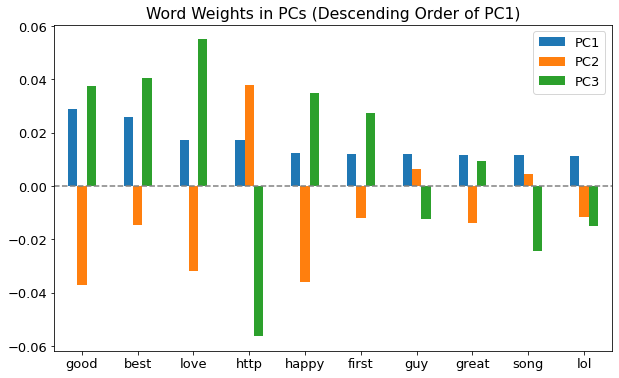

In [31]:
pc.sort_values('PC1', ascending = False)[['PC1', 'PC2', 'PC3']][1:11].plot.bar(figsize = (10,6))
plt.axline((0,0), (9,0), linestyle='--', color='grey', label='Line through Points')
plt.xticks(rotation = 0)
plt.title('Word Weights in PCs (Descending Order of PC1)')
plt.xlabel('')
plt.show()

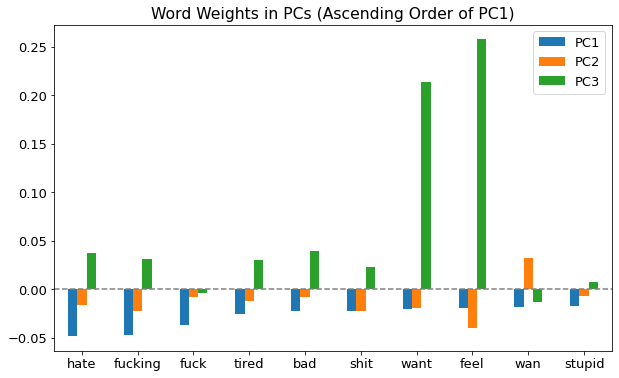

In [32]:
pc.sort_values('PC1', ascending = True)[['PC1', 'PC2', 'PC3']][1:11].plot.bar(figsize = (10,6))
plt.axline((0,0), (9,0), linestyle='--', color='grey', label='Line through Points')
plt.xticks(rotation = 0)
plt.title('Word Weights in PCs (Ascending Order of PC1)')
plt.xlabel('')
plt.show()

### 6.2 Naive Bayes

In [33]:
# Split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(extended_df, Y, test_size=0.2, random_state=30, stratify = Y)

In [34]:
model = MultinomialNB()
model.fit(X_train.iloc[:, :-2], y_train)

# Predict and evaluate
y_pred = model.predict(X_test.iloc[:, :-2])
print('Training Accuracy:', accuracy_score(y_train, model.predict(X_train.iloc[:, :-2])))
print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Training Accuracy: 0.86775
Testing Accuracy: 0.793
              precision    recall  f1-score   support

           0       0.98      0.59      0.74       494
           1       0.71      0.99      0.83       506

    accuracy                           0.79      1000
   macro avg       0.85      0.79      0.78      1000
weighted avg       0.85      0.79      0.78      1000

Confusion Matrix:
[[292 202]
 [  5 501]]


In [35]:
confusion_matrix(y_test, y_pred)

array([[292, 202],
       [  5, 501]])

### 6.3 Random Forest

In [36]:
model = RandomForestClassifier(min_samples_leaf = 15, min_samples_split = 10)

model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print('Training Accuracy:', accuracy_score(y_train, model.predict(X_train)))
print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Training Accuracy: 0.848
Testing Accuracy: 0.839
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       494
           1       0.86      0.81      0.84       506

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000

Confusion Matrix:
[[427  67]
 [ 94 412]]


In [37]:
confusion_matrix(y_test, y_pred)

array([[427,  67],
       [ 94, 412]])

### 6.4 XGBoost

In [38]:
model = xgb.XGBClassifier(max_depth = 3)

model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print('Training Accuracy:', accuracy_score(y_train, model.predict(X_train)))
print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Training Accuracy: 0.9425
Testing Accuracy: 0.885
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       494
           1       0.90      0.87      0.88       506

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.88      1000
weighted avg       0.89      0.89      0.88      1000

Confusion Matrix:
[[446  48]
 [ 67 439]]


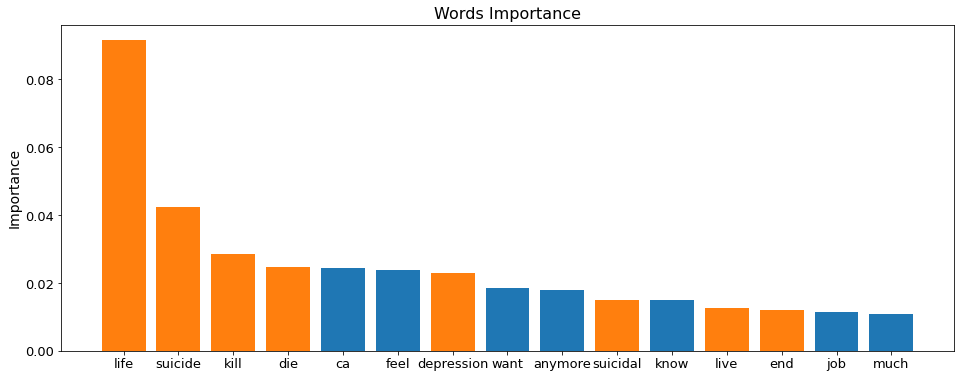

In [39]:
# Constrcut feature importance metrics
importances = pd.DataFrame({'feature': extended_df.columns,'importance': model.feature_importances_})

# Leave features with importance > 0
feature_importances = importances[importances['importance'] > 0].sort_values('importance', ascending = False)
colors = ['#ff7f0e'  if x in [0,1,2,3,6, 9, 11, 12] else '#1f77b4' for x in range(15)]
fig, ax = plt.subplots(figsize = (16,6))
ax.bar(feature_importances['feature'][:15], feature_importances['importance'][:15].values, color = colors)
plt.xticks(rotation = 0)
plt.ylabel('Importance', fontsize = 14)
plt.title('Words Importance', fontsize = 16)
# for label in [0,1,2,3,6]:
#     ax.get_xticklabels()[label].set_color("#ff7f0e")

plt.show()

### 6.5 Neural Network

In [40]:
model = MLPClassifier(hidden_layer_sizes=(3,3,3), learning_rate = 'constant',random_state=1)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print('Training Accuracy:', accuracy_score(y_train, model.predict(X_train)))
print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

/Users/shfovt/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy: 0.99825
Testing Accuracy: 0.888
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       494
           1       0.89      0.89      0.89       506

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

Confusion Matrix:
[[440  54]
 [ 58 448]]


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=30, stratify = Y)

model = xgb.XGBClassifier(max_depth = 3)

model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print('Training Accuracy:', accuracy_score(y_train, model.predict(X_train)))
print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Training Accuracy: 0.92375
Testing Accuracy: 0.852
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       494
           1       0.85      0.86      0.85       506

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000

Confusion Matrix:
[[416  78]
 [ 70 436]]
